In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import morphology

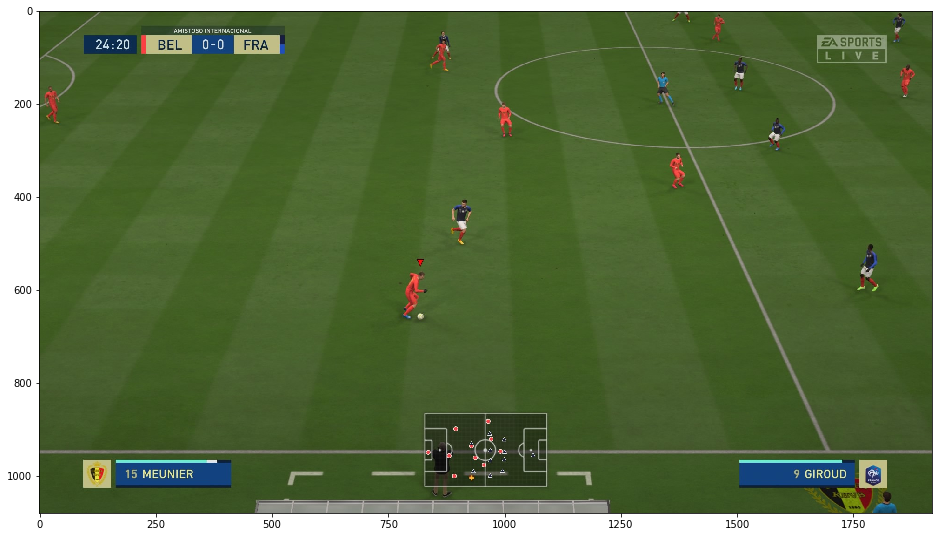

In [2]:
img = cv2.imread('../images/FIFA 20 Match Day ao Vivo 0-0 BEL X FRA, 1º tempo.jpg')
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Convertendo a image para HSV e utilizando uma mascará para separar o campo dos jogadores

* A máscara que estamos aplicando nesse passo é baseada em 2 valores HSV que representam um range de cores verdes.
* A máscara indicará como 1 (ou 255) todos os pixels da imagem que estiverem dentro desse range, caso contrário, será pintada com 0.
* Para aplicar a máscara é realizada uma operação bitwise AND entre a imagem em BGR e a máscara.

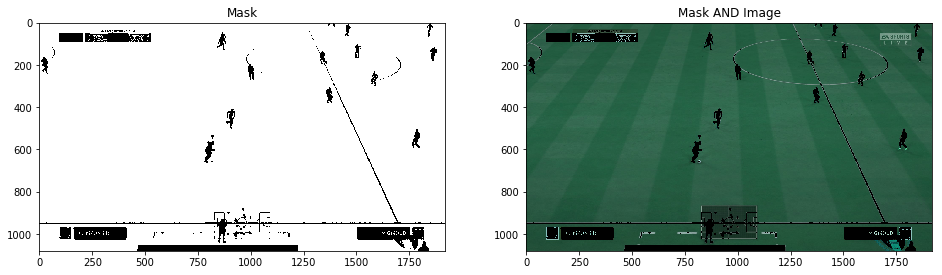

In [3]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(figsize=(16,8))
lower_green = np.array([30, 40, 40])
upper_green = np.array([70, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

plt.subplot(121)
plt.title('Mask')
plt.imshow(mask , cmap='gray')

res = cv2.bitwise_and(img, img, mask=mask)
plt.subplot(122)
plt.title('Mask AND Image')
plt.imshow(res, cmap='gray')

## Morphological Operations e Thresholding

* A primeira parte é realizar uma operação de Thresholding na imagem.
    * Utilizamos duas técnicas em conjunto: Otsu Thresholding e o Binary Thresholding


* Para as operações morfológicas, testamos duas abordagens diferentes para melhorar a qualidade da imagem:
    * A primeira abordagem foi utilizando uma operação de **Closing** para tirar possíveis ruídos da imagem.
    * A segunda abordagem foi simplesmente complementar a primeira com uma operação de Opening.
    
    * A primeira abordagem (somente **Closing**) funcionou melhor em vídeos. Acreditamos que seja porque a qualidade de um frame de um vídeo seja menor do que a das imagens coletadas, o que faz com que a remoção de ruídos em excesso gere a **perda de informações importantes** para o algoritmo.
    * Enquanto isso, utilizar **Opening** depois do **Closing** funcionou melhor nas imagens coletadas, já que a qualidade é melhor. Além disso, essa abordagem nos permitiu **remover pequenos objetos** na imagem como alguns pedaços das linhas do campo e também o minimapa do jogo.

Text(0.5, 1.0, 'Opening after closing image ')

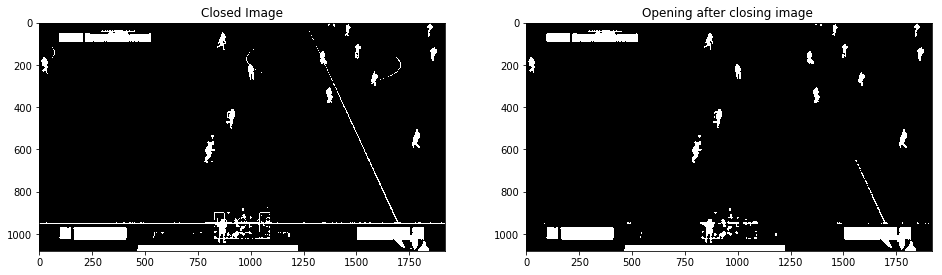

In [4]:
plt.figure(figsize=(16,16))

res_bgr = cv2.cvtColor(res, cv2.COLOR_HSV2BGR)
res_gray = cv2.cvtColor(res_bgr, cv2.COLOR_BGR2GRAY)

thresh = cv2.threshold(res_gray, 127, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

kernel = morphology.disk(3).astype(np.uint8)
closed_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

plt.subplot(121)
plt.imshow(closed_image, cmap='gray')
plt.title("Closed Image")

plt.subplot(122)
plt.imshow(opened_image, cmap='gray')
plt.title("Opening after closing image ")

## Detecção dos Jogadores de cada time

* Após aplicar a máscara, deixando apenas os elementos relevantes para a detecção dos jogadores, aplicamos um método de detecção de contornos.
* Para cada contorno encontrado, aplicamos o seguinte método:
    * Desenhamos um retângulo que envolve esse contorno utiliza o método boundingRect do OpenCV.
    * Com as dimensões do retângulo retornado, filtramos o retângulo baseado no tamanho das dimensões, excluindo objetos pequenos como a bola, e objetos grandes como contornos de linhas do campo.
    * Recortamos esse retângulo na imagem, e aplicamos sobre ele novas máscaras, com o objetivo de detectar os jogadores e o time a qual ele pertence, utilizando a cor da sua camiseta.
    * As máscaras utilizadas são de range de cores azul e vermelha, pois as imagens testadas eram de times que possuíam majoritariamente essas cores na camiseta.
    * Após aplicar as máscaras, contamos o número de pixels encontrados daquela cor, sendo assim capazes de separar os jogadores dos dois times.

In [5]:
_, contours, hierarchy = cv2.findContours(opened_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
font = cv2.FONT_HERSHEY_SIMPLEX

#blue range
lower_blue = np.array([90,10,2])
upper_blue = np.array([130,110,255])
#Red range
lower_red = np.array([0,120,70])
upper_red = np.array([10,255,255])

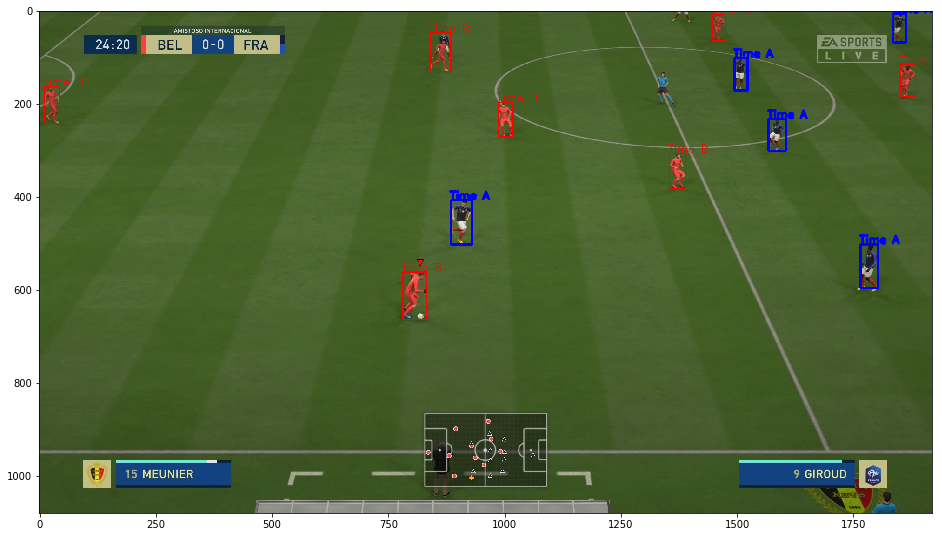

In [6]:
output_img = img.copy()
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h >= (1.2) * w and h <= 150:
        if w > 5 and h >= 5:
            player_img = img[y : y + h, x : x + w]
            player_hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)
            
            #If player has blue jersy
            mask1 = cv2.inRange(player_hsv, lower_blue, upper_blue)
            res1 = cv2.bitwise_and(player_img, player_img, mask=mask1)
            res1 = cv2.cvtColor(res1,cv2.COLOR_HSV2BGR)
            res1 = cv2.cvtColor(res1,cv2.COLOR_BGR2GRAY)
            nzCountBlue = cv2.countNonZero(res1)
            
            #If player has red jersy
            mask2 = cv2.inRange(player_hsv, lower_red, upper_red)
            res2 = cv2.bitwise_and(player_img, player_img, mask=mask2)
            res2 = cv2.cvtColor(res2,cv2.COLOR_HSV2BGR)
            res2 = cv2.cvtColor(res2,cv2.COLOR_BGR2GRAY)
            nzCountRed = cv2.countNonZero(res2)
            if(nzCountBlue >=100):
                cv2.putText(output_img, 'Time A', (x-2, y-2), font, 0.8, (255,0,0), 3, cv2.LINE_AA)
                cv2.rectangle(output_img,(x,y),(x+w,y+h),(255,0,0),3)
            elif(nzCountRed >=100):
                cv2.putText(output_img, 'Time B', (x-3, y-2), font, 0.8, (0,0,255), 1, cv2.LINE_AA)
                cv2.rectangle(output_img,(x,y),(x+w,y+h),(0,0,255),2)
                
plt.figure(figsize=(16,16))

plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

## Conclusões:


* O algoritmo depende majoritariamente do range da cor das camisetas dos times para funcionar. Por isso, escolher um range para a cor delas é essencial para a detecção dos jogadores.
* Tivemos muita dificuldade em achar um range bom para as imagens testadas pois é muito díficil escolher range de cores em HSV, especificamente no modelo HSV do OpenCV que tem um intervalo diferente do HSV normal.

* O método utilizado é muito dependente das cores, ele é muito suscetível a falhas, como por exemplo um jogador que possui camiseta azul e meia vermelha pode confundir o algoritmo.

* Além disso, o tamanho da imagem também interfere no resultado, pois como utilizamos uma contagem de pixels que deram match com aquela cor dada, imagens maiores (com mais pixels) podem dar resultados diferentes de imagens menores.